# Data Mining & Machine Learning - Regression Part 2

### Case 2: Prediction of Footballer Values with Supervised Learning

83109 Samuel Didovic<br>
86368 Isabel Lober<br>
85915 Pascal Seitz<br>

Lecturer: Prof. Dr. Adrian Moriariu

## Table of Contents
1. [Step 1: Investigation of the dataset's basics](#intro)
2. [Step 2: Investigation of missing values](#second)
    1. [2.1 `type2`](#sub21)
    2. [2.2`percentage_male`](#sub22)
    3. [2.3`height_m` and `weight_kg`](#sub23)
    4. [2.4 First conclusions](#sub24)
3. [Step 3: Feature Engineering](#third)
    1. [3.1 NaN replacement](#sub31)
    2. [3.2 Imputation](#sub32)
    3. [3.3 Introducing a new feature](#sub33)
    4. [3.4 Check on changes](#sub34)
    5. [3.5 `capture_rate`](#sub35)
    6. [3.6 Final steps](#sub36)
4. [Step 4: Save the cleaned dataset](#fourth)

In [159]:
import warnings
warnings.filterwarnings("ignore")

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
import seaborn as sns
import matplotlib as mpl

### Step 1: Investigation of the dataset's basics <a name = "intro"></a>

In [161]:
# Loading the data
filenames = ["transfermarkt_fbref_201718", "transfermarkt_fbref_201819", "transfermarkt_fbref_201920"]

# Data folder
data_dir = "football-data"

dfs = [] # List to store the dataframes

# Load the data from each CSV file
for i, file in enumerate(filenames):
    # Construct the file path
    file_path = f"{data_dir}/{file}.csv"
    
    # Read the CSV file directly, specifying the delimiter and thousands separator
    data = pd.read_csv(file_path, delimiter=';', thousands=',')
    
    # Add a column for the year of the data
    data['year'] = 2017 + i
    
    # Append the dataframe to the list
    dfs.append(data)
    
df = pd.concat(dfs) # Turning the list of dataframes into one dataframe
data = df.copy() # Creating a copy of the dataframe for later use

print("--------------------------------------")
print(f"Amount of samples: {len(df)}. Amount of features: {len(df.columns)}")
print("--------------------------------------")


--------------------------------------
Amount of samples: 7108. Amount of features: 402
--------------------------------------


In [162]:
df.head()

,Unnamed: 0,player,nationality,position,squad,age,birth_year,value,height,position2,...,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season,year,Column1
0,379.0,Burgui,es ESP,"FW,MF",Alavés,23.0,1993.0,1800000.0,186.0,attack - Left Winger,...,53.2,-14.2,-0.37,16819.0,0.0,0.0,0.0,201718#,2017,NaN
1,2530.0,Raphaël Varane,fr FRA,DF,Real Madrid,24.0,1993.0,70000000.0,191.0,Defender - Centre-Back,...,45.4,37.9,1.00,66161.0,1.0,1.0,0.0,201718#,2017,NaN
2,721.0,Rubén Duarte,es ESP,DF,Alavés,21.0,1995.0,2000000.0,179.0,Defender - Left-Back,...,53.2,-14.2,-0.37,16819.0,0.0,0.0,0.0,201718#,2017,NaN
3,2512.0,Samuel Umtiti,fr FRA,DF,Barcelona,23.0,1993.0,60000000.0,182.0,Defender - Centre-Back,...,41.1,37.2,0.98,66603.0,1.0,0.0,0.0,201718#,2017,NaN
4,882.0,Manu García,es ESP,MF,Alavés,31.0,1986.0,1800000.0,183.0,midfield - Defensive Midfield,...,53.2,-14.2,-0.37,16819.0,0.0,0.0,0.0,201718#,2017,NaN


Transpose the dataset to provide an appropriate overview, since not every feature is displayed.<br>
Additionally, display some random rows to get a proper understanding of the data.

In [163]:
from tabulate import tabulate

# Set display options to show all rows
pd.set_option('display.max_rows', None)

columns_overview = df.sample(1).T # Transpose the dataset to get a better overview. Also, display some random rows to get a proper understanding of the data.
# Convert DataFrame to a pretty-printed table string
table_string = tabulate(columns_overview, headers='keys', tablefmt='psql')

print(table_string) # Print the table string

# Write the string to a text file
with open('columns_overview.txt', 'w') as file:
    file.write(table_string)

print("File has been written and saved as 'columns_overview.txt'.")
print("--------------------------------------")

# Reset the display options after printing
pd.reset_option('display.max_rows')

+----------------------------------------+-------------------------+
|                                        | 468                     |
|----------------------------------------+-------------------------|
| Unnamed: 0                             | 929.0                   |
| player                                 | Olivier Giroud          |
| nationality                            | fr FRA                  |
| position                               | FW                      |
| squad                                  | Chelsea                 |
| age                                    | 30.0                    |
| birth_year                             | 1986.0                  |
| value                                  | 18000000.0              |
| height                                 | 193.0                   |
| position2                              | attack - Centre-Forward |
| foot                                   | left                    |
| league                          

From our initial exploratory data analysis, we have gained several insights into the dataset's structure and content:

- **Data Types Observed**:
  - **String Data**: Attributes like `player`, `nationality`, `position`, `squad`, `league`, and `foot` are categorical data stored as strings. These features describe qualitative aspects of the players and their playing environment.
  - **Numerical Data**: Attributes such as `age`, `birth_year`, `value`, `height`, `games`, `minutes`, `goals`, and `assists`, along with various performance metrics like `xg` (expected goals), `xa` (expected assists), and `passes` are stored as integers or floats. These provide quantitative measurements of player performances and physical characteristics.
  
- **Handling Missing Values**:
  - The dataset may contain missing values (`NaN` values), which are common in comprehensive sports data. This can occur in several scenarios, such as incomplete data capture, players not participating in certain games, or unrecorded metrics.
  - Specific attributes such as performance metrics (`goals_per90`, `assists_per90`, etc.) often have zero values, which could indicate either no activity in these areas or insufficient playing time to gather data. It's crucial to distinguish between genuine zeros (no activity) and cases where data may not be recorded due to players not playing in certain matches.

- **Features Warranting Further In-depth Review**:
  - **Performance Metrics**: Exploring how different metrics like `xg`, `xa`, `passes`, and `shots` are distributed among players can reveal insights into player efficiency and team strategies.
  - **Physical Attributes**: Analyzing features like `height` and `age` can help in understanding physical diversity in the dataset and potential correlations with player roles and performance.
  - **Participation Metrics**: Metrics like `games`, `minutes`, and `starts` are critical for understanding player utilization and impact. Analyzing the distribution of these features can help identify key players, squad rotation, and injury impacts.
  - **Missing Data Patterns**: Identifying patterns in missing data can help in understanding biases in the data collection process or in the dataset itself. For instance, backup players might have more missing data points in performance metrics.

Therefore, it is beneficial to conduct a detailed review of these aspects to ensure a comprehensive understanding of the dataset before proceeding with further analysis or model building.


In [164]:
print("Data Information")
print(df.info())
print("--------------------------------------")

Data Information
<class 'pandas.core.frame.DataFrame'>
Index: 7108 entries, 0 to 2643
Columns: 402 entries, Unnamed: 0 to Column1
dtypes: float64(393), int64(1), object(8)
memory usage: 21.9+ MB
None
--------------------------------------


This gives insights of the data type for each column.<br>
In sum, there's a total number of 
- **393** columns containing **float types** 
- **1** columns containing **integer types**
- **8** columns containing **object types**.

Examine some basic statistics.

In [165]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2232.0,1.339719e+03,7.770203e+02,0.0,656.75,1347.5,2013.25,2686.0
age,6976.0,2.542317e+01,4.444526e+00,0.0,22.00,25.0,28.00,41.0
birth_year,6976.0,1.991136e+03,4.790624e+01,0.0,1989.00,1992.0,1996.00,2004.0
value,6976.0,1.023844e+07,1.654409e+07,50.0,1500000.00,4000000.0,12000000.00,200000000.0
height,6975.0,1.819604e+02,9.470125e+00,0.0,178.00,183.0,187.00,203.0
...,...,...,...,...,...,...,...,...
CL,6976.0,1.836296e-01,3.872096e-01,0.0,0.00,0.0,0.00,1.0
WinCL,6976.0,9.317661e-03,9.608416e-02,0.0,0.00,0.0,0.00,1.0
CLBestScorer,6696.0,4.480287e-04,2.116353e-02,0.0,0.00,0.0,0.00,1.0
year,7108.0,2.018058e+03,8.262711e-01,2017.0,2017.00,2018.0,2019.00,2019.0


**Calculating the correlation matrix**:
  - **To be considered**: We have 8 columns/features of type object which are non numbers. We will need to ignore these while computing the correlation matrix 

In [166]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])

# Calculating the correlation matrix of the numeric columns only
correlation_matrix = numeric_df.corr()

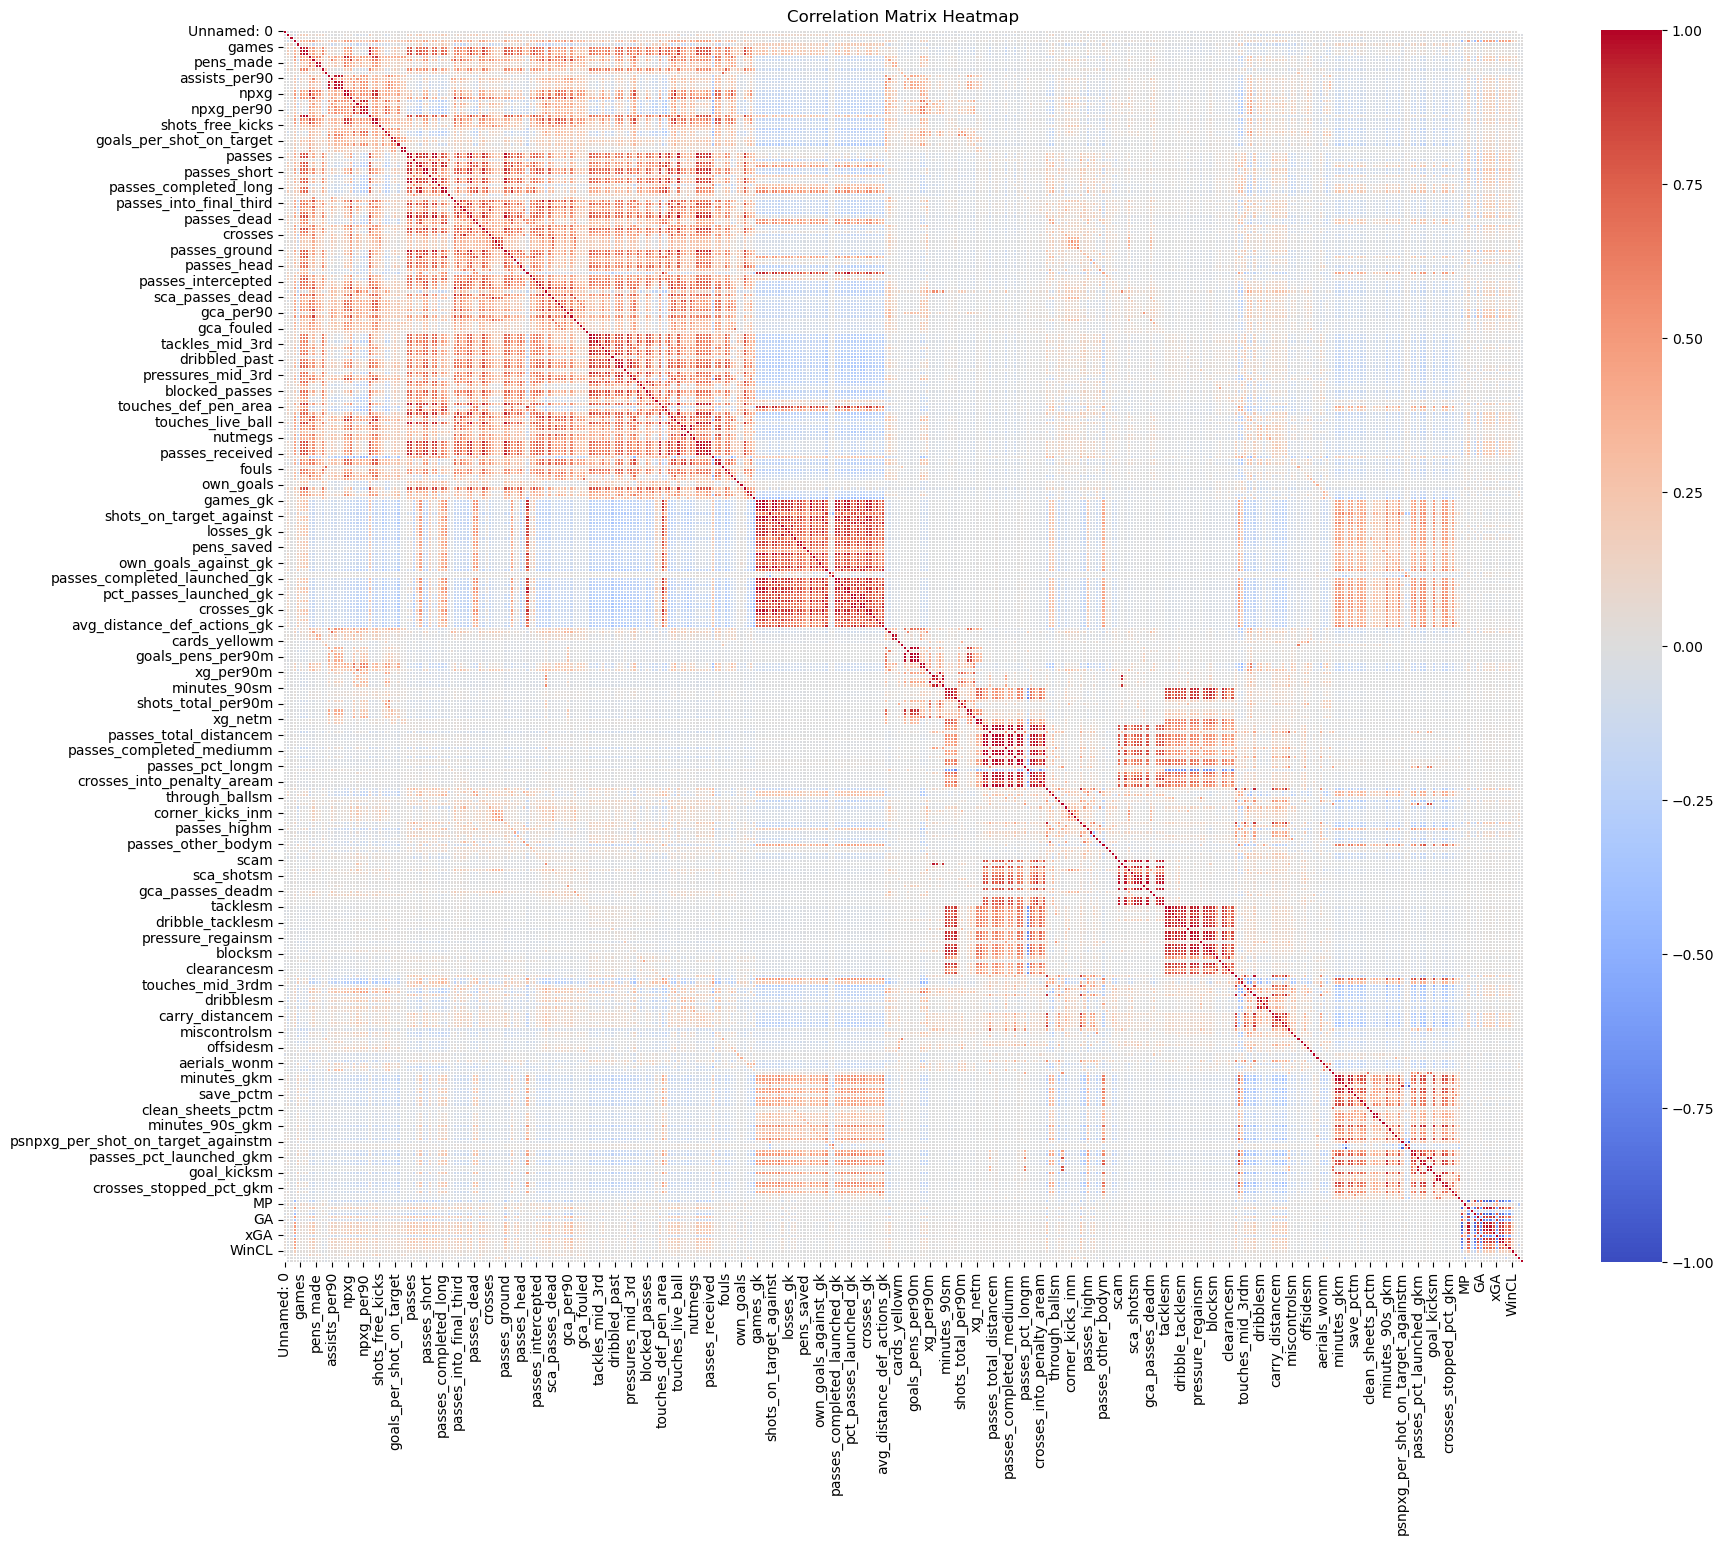

In [167]:
# Increase the figure size
plt.figure(figsize=(20, 16))
# Plot the heatmap
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

Defining an empty list, where during the EDA process columns that need to be removed will be appended to. These columns will be removed at the end, then the data will be saved.

In [168]:
columns_to_remove = [] # List to store the columns to removed at the end

### Step 2: Investigation of missing values <a name = "second"></a>

Examine whether the dataset contains null values.<br>
Based on the initial insights there must at least a few.

In [169]:
missing_values_summary = df.isnull().sum()
filtered_missing_values = missing_values_summary[missing_values_summary > 0]  # Filter columns with missing values

# Convert the Series to a string
missing_values_str = filtered_missing_values.to_string()

# Print the content
print(missing_values_str)

# Write the string to a text file
with open('missing_values_summary.txt', 'w') as file:
    file.write(missing_values_str)

print("--------------------------------------")
print("File has been written and saved as 'missing_values_summary.txt'.")
print("--------------------------------------")

Unnamed: 0                                4876
player                                     132
nationality                                132
position                                   132
squad                                      132
age                                        132
birth_year                                 132
value                                      132
height                                     133
position2                                  132
foot                                       155
league                                     132
games                                      132
games_starts                               132
minutes                                    132
goals                                      132
assists                                    132
pens_made                                  132
pens_att                                   132
cards_yellow                               132
cards_red                                  132
goals_per90  

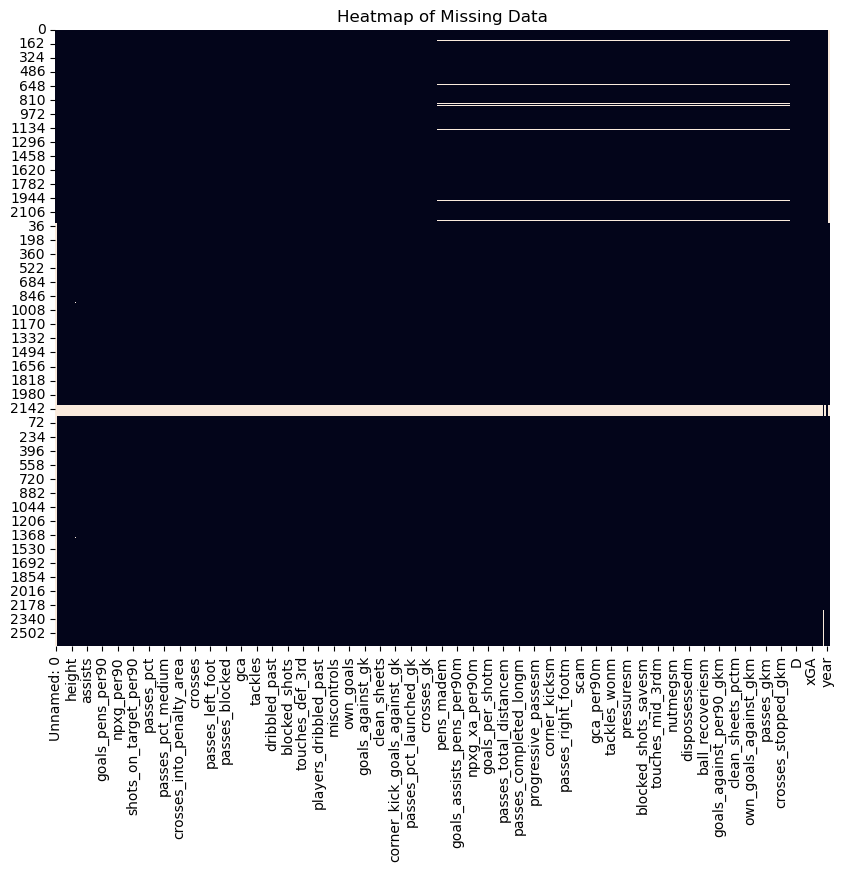

In [170]:
# Heatmap of missing values to explore dependencies
plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Heatmap of Missing Data')
plt.show()

## Analysis of Missing Data

The exploratory data analysis has revealed a significant pattern of missing values across various features in our dataset. Here's a structured approach to further handle and investigate these missing values:

### Understanding Patterns of Missingness

- **Consistency in Missing Data**: Several features exhibit the same number of missing values(132, 264), suggesting a possible systematic issue or non-applicability in certain cases.
- **Features with Extensive Missing Data**: Particularly high levels of missing data in specific columns (`Unnamed: 0`, `Column1`, and `CLBestScorer`) necessitate a deeper investigation to determine their relevance and potential impact on the analysis.



### Consistency in Missing Data

In [171]:
# Calculate the percentage of missing values in each row
missing_percentage_samples = df.isnull().sum(axis=1) / len(df.columns) * 100

# Add this as a new column to the DataFrame for easy inspection
df['missing_percentage'] = missing_percentage_samples

# Select a few key features to display along with the missing percentage
# Adjust the column names as per your DataFrame
selected_features = ['player', 'nationality', 'squad', 'missing_percentage']

# Filter to show only rows with more than 50% missing values and display selected features
filtered_df = df[df['missing_percentage'] > 50][selected_features]
print(filtered_df.sort_values(by='missing_percentage', ascending=False))


     player nationality squad  missing_percentage
2100    NaN         NaN   NaN           99.502488
2183    NaN         NaN   NaN           99.502488
2197    NaN         NaN   NaN           99.502488
2196    NaN         NaN   NaN           99.502488
2195    NaN         NaN   NaN           99.502488
...     ...         ...   ...                 ...
2138    NaN         NaN   NaN           99.502488
2137    NaN         NaN   NaN           99.502488
2136    NaN         NaN   NaN           99.502488
2135    NaN         NaN   NaN           99.502488
2231    NaN         NaN   NaN           99.502488

[132 rows x 4 columns]


### Python Code to Remove Highly Incomplete Rows
This approach ensures that our dataset is now free of rows where a majority of the data is missing, thus improving the quality of our dataset for subsequent analyses.

In [172]:
# Filtering out rows where missing_percentage is greater than 50%
df = df[df['missing_percentage'] <= 50]

# Confirm the removal by printing the shape of the new DataFrame and the original DataFrame
print(f"Original DataFrame shape: {data.shape}")
print(f"New DataFrame shape after removing high missing percentage rows: {df.shape}")
print(f"Removed {data.shape[0] - df.shape[0]} rows with more than 50% missing values.")


Original DataFrame shape: (7108, 402)
New DataFrame shape after removing high missing percentage rows: (6976, 403)
Removed 132 rows with more than 50% missing values.


### Features with Extensive Missing Data

In [173]:
def print_missing_values(df):
    """
    Prints the percentage of missing values for each feature in a DataFrame that has more than 0% missing values.

    Parameters:
    - df (pd.DataFrame): The DataFrame for which missing values percentages are calculated.

    Returns:
    - None, but prints a sorted list of features with their corresponding percentage of missing values.
    """
    # Calculate the percentage of missing values for each feature
    missing_percentage = df.isnull().sum() / len(df) * 100

    # Filter and print features with more than 0% missing values, sorted from highest to lowest
    missing_values_sorted = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
    print("Missing Values Percentage (sorted):")
    print(missing_values_sorted)
    
    return missing_percentage
    
_ = print_missing_values(df)

Missing Values Percentage (sorted):
Unnamed: 0            68.004587
Column1               31.995413
CLBestScorer           5.905963
tackles_mid_3rdm       1.892202
pass_targetsm          1.892202
                        ...    
passes_left_footm      1.892202
passes_right_footm     1.892202
pens_madem             1.892202
foot                   0.329702
height                 0.014335
Length: 188, dtype: float64


As previously stated, there are particularly high levels of missing data in specific columns (`Unnamed: 0`, `Column1`, and `CLBestScorer`)

### 2.1 `Unnamed: 0`<a name = "sub22"></a>

In [174]:
df[['Unnamed: 0', 'Column1']].head

<bound method NDFrame.head of       Unnamed: 0  Column1
0          379.0      NaN
1         2530.0      NaN
2          721.0      NaN
3         2512.0      NaN
4          882.0      NaN
...          ...      ...
2639         NaN   1997.0
2640         NaN   2202.0
2641         NaN   2523.0
2642         NaN   2567.0
2643         NaN   2615.0

[6976 rows x 2 columns]>

### Investigation of Potential Data Split Between Two Columns

#### Objective
Our goal is to analyze the relationship between the columns 'Unnamed: 0' and 'Column1' to verify if there's a pattern where a value in one column corresponds to a missing value in the other. This might suggest that the data from one column was split into two.

#### Methods and Analysis

##### Step 1: Creating Indicator Columns for NaNs
To facilitate this analysis, we first create indicator columns that flag whether each row in 'Unnamed: 0' and 'Column1' contains NaN values:
- `Unnamed: 0_is_NaN`: `True` if NaN, `False` otherwise.
- `Column1_is_NaN`: `True` if NaN, `False` otherwise.

These columns help us to easily visualize and calculate the correlation between the presence of NaNs across the two columns.

In [175]:
# Create indicator columns: True if the value is missing, False otherwise
df['Unnamed: 0_is_NaN'] = df['Unnamed: 0'].isnull() 
df['Column1_is_NaN'] = df['Column1'].isnull() 

##### Step 2: Examining the Relationship
We then examine the relationship between these indicators to see if NaNs in one column correlate with non-NaNs in the other. This is done by comparing the indicators and counting the number of rows that fit this pattern:
- We calculate the logical XOR between the two indicators to identify rows where the presence of a NaN in one column corresponds to a non-NaN in the other.


In [176]:
# Analyze the pattern
pattern_check = df[['Unnamed: 0_is_NaN', 'Column1_is_NaN']]

# Display the relationship
print(pattern_check.head(10))

# Checking the specific pattern: when one is NaN, the other is not NaN
pattern_analysis = (df['Unnamed: 0_is_NaN'] != df['Column1_is_NaN'])
print(f"Number of rows where NaNs in 'Unnamed: 0' align with non-NaNs in 'Column1' and vice versa: {pattern_analysis.sum()}. Total rows: {len(df)}")


   Unnamed: 0_is_NaN  Column1_is_NaN
0              False            True
1              False            True
2              False            True
3              False            True
4              False            True
5              False            True
6              False            True
7              False            True
8              False            True
9              False            True
Number of rows where NaNs in 'Unnamed: 0' align with non-NaNs in 'Column1' and vice versa: 6976. Total rows: 6976


##### Step 3: Visualizing the Pattern
To visualize this relationship, we:
- Create a crosstab of the two indicator columns. This table shows the counts of each combination of NaN and non-NaN across the columns.

Column1_is_NaN     False  True 
Unnamed: 0_is_NaN              
False                  0   2232
True                4744      0


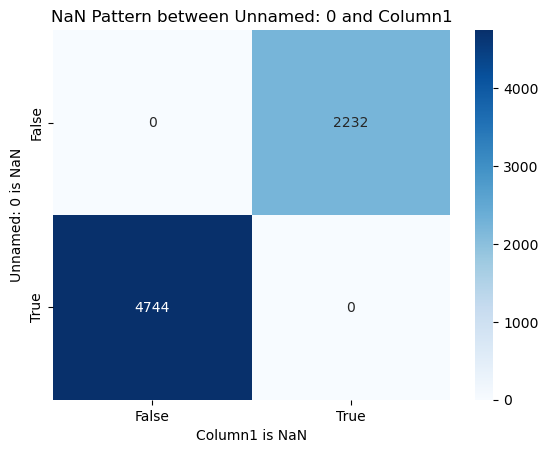

In [177]:
# Create a crosstab
ctab = pd.crosstab(pattern_check['Unnamed: 0_is_NaN'], pattern_check['Column1_is_NaN'])
print(ctab)

# Heatmap of the crosstab
sns.heatmap(ctab, annot=True, cmap="Blues", fmt='d')
plt.title('NaN Pattern between Unnamed: 0 and Column1')
plt.xlabel('Column1 is NaN')
plt.ylabel('Unnamed: 0 is NaN')
plt.show()

### Decision on `Unnamed: 0` and `Column1` Features

#### Analysis Summary
The heatmap analysis has clearly demonstrated a pattern between `Unnamed: 0` and `Column1`: when one column contains a missing value, the other contains a non-missing value. This consistent pattern indicates that the data originally from a single source was likely split into these two columns as a result of a systematic error.

#### Decision Rationale
Given the observed dependencies between these two columns:
- **Redundant Data**: The pattern suggests redundancy between the columns, as they appear to complement each other's missing information.
- **Data Integrity**: Combining these columns into a single `Combined` column will not only simplify the data structure but also enhance the completeness and utility of the data, reducing complexities in future analyses.

#### Action
**Merge the Features**: We have decided to merge `Unnamed: 0` and `Column1` into a new column called `player_id`. The steps involved are:
- **Create `player_id` Column**: Implement a merging strategy where non-null values from `Column1` fill the null values in `Unnamed: 0`, and vice versa, ensuring no data is lost in the transition.
- **Review and Validate**: After merging, conduct a comprehensive review of the new column to confirm its integrity and suitability for inclusion in subsequent data analysis processes.

This approach is intended to restore the dataset’s original integrity, optimizing both the quality and the usability of the data for enhanced analytical outcomes.


In [178]:
df['player_id'] = df['Unnamed: 0'].fillna(df['Column1']) # Fill the missing values in 'player_id' with values from 'Unnamed: 0' and 'Column1'

df['player_id'] = df['player_id'].fillna(df['Column1']) # Fill the missing values in 'player_id' with values from 'Column1'

# Display the first few rows to confirm the new column is correct
print(df[['Unnamed: 0', 'Column1', 'player_id']])

      Unnamed: 0  Column1  player_id
0          379.0      NaN      379.0
1         2530.0      NaN     2530.0
2          721.0      NaN      721.0
3         2512.0      NaN     2512.0
4          882.0      NaN      882.0
...          ...      ...        ...
2639         NaN   1997.0     1997.0
2640         NaN   2202.0     2202.0
2641         NaN   2523.0     2523.0
2642         NaN   2567.0     2567.0
2643         NaN   2615.0     2615.0

[6976 rows x 3 columns]


In [179]:
columns_to_remove.extend(['Unnamed: 0', 'Column1', 'missing_percentage', 'Unnamed: 0_is_NaN', 'Column1_is_NaN']) # Add the columns to the list of columns to remove 

In [180]:
_ = print_missing_values(df)

Missing Values Percentage (sorted):
Unnamed: 0            68.004587
Column1               31.995413
CLBestScorer           5.905963
tackles_mid_3rdm       1.892202
pass_targetsm          1.892202
                        ...    
passes_left_footm      1.892202
passes_right_footm     1.892202
pens_madem             1.892202
foot                   0.329702
height                 0.014335
Length: 188, dtype: float64


#### 2.2 `CLBestScorer  `<a name = "sub22"></a>

In [181]:
# Define a threshold for high correlations
threshold = 0.2

# 'CLBestScorer' is our specific column of interest
high_correlations = correlation_matrix['CLBestScorer'][(correlation_matrix['CLBestScorer'].abs() > threshold)]

# Print high correlations
print(f"High correlations with 'CLBestScorer' above {threshold}:")
print(high_correlations)

High correlations with 'CLBestScorer' above 0.2:
CLBestScorer    1.0
Name: CLBestScorer, dtype: float64


In [182]:
print(f"Mean: {df['CLBestScorer'].mean()},\nMedian: {df['CLBestScorer'].median()},\nCorrelation to target: {df['CLBestScorer'].corr(df['value'])}")

Mean: 0.0004570383912248629,
Median: 0.0,
Correlation to target: 0.11663154350761214


### Decision on `CLBestScorer` Feature

#### Analysis Summary
Upon reviewing the `CLBestScorer` feature, we noted the following:
- The feature primarily contains zero values as evidenced by its median and prevalent mean close to zero.
- Its correlation with the target variable is relatively low (approximately 0.116), indicating a weak linear relationship.
- No significant correlations were found between `CLBestScorer` and other features above the threshold of 0.2.

#### Decision Rationale
Given the low predictive relevance and the sparse nature of the data:
- **Sparse Data:** The dominance of zeros suggests that for the majority of observations, this feature does not provide additional information.
- **Low Correlation:** The minimal correlation with the target variable does not justify retaining this feature in the context of building predictive models or conducting robust data analysis.

#### Action
**Remove the Feature:** Based on the above findings, we have decided to remove the `CLBestScorer` feature from our dataset. This decision aims to streamline our analysis, focusing on more impactful variables and enhancing the overall efficiency and effectiveness of our predictive models.

This measure will ensure that our modeling efforts are concentrated on features that offer more substantial insights and contribute to the accuracy of our predictions.


In [183]:
columns_to_remove.extend(['CLBestScorer']) # Add the column to the list of columns to remove

In [184]:
_ = print_missing_values(df)

Missing Values Percentage (sorted):
Unnamed: 0            68.004587
Column1               31.995413
CLBestScorer           5.905963
tackles_mid_3rdm       1.892202
pass_targetsm          1.892202
                        ...    
passes_left_footm      1.892202
passes_right_footm     1.892202
pens_madem             1.892202
foot                   0.329702
height                 0.014335
Length: 188, dtype: float64


It is very interesting that 183 features share the same percentage of missing values. What is behind this?

#### 2.3 Features with missing value percentage of `1.892202 %`<a name = "sub23"></a>

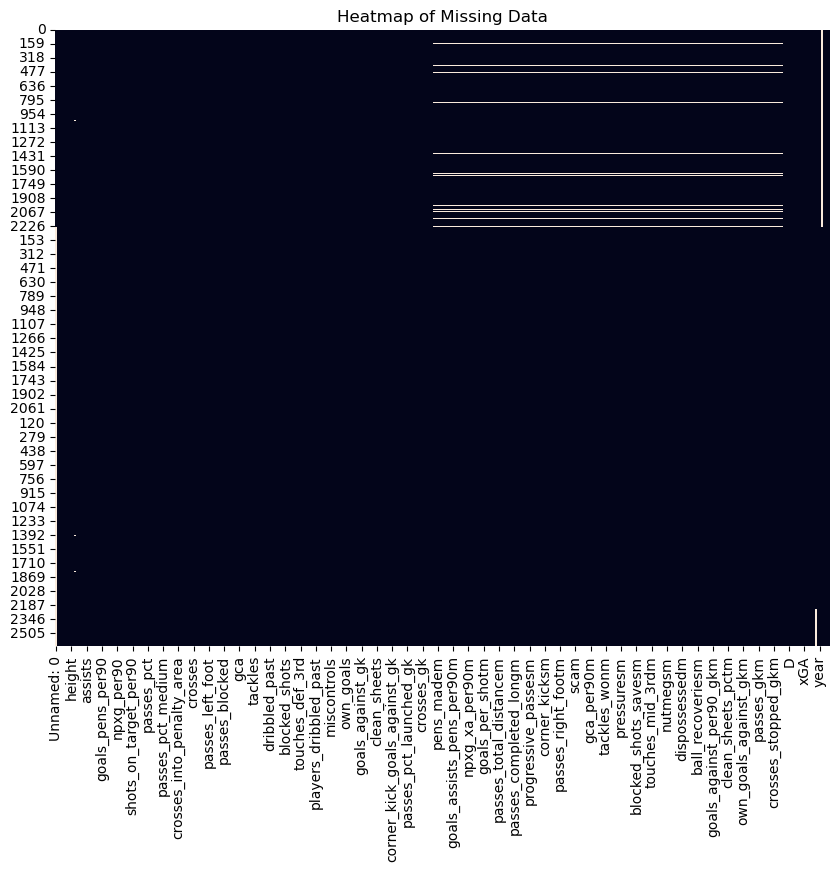

In [185]:
# Heatmap of missing values to explore dependencies
plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Heatmap of Missing Data')
plt.show()

In [186]:
print(f"Affected amount of samples: {df['tackles_wonm'].isnull().sum()}")

Affected amount of samples: 132


### Decision on Features with Uniform Missing Entries

#### Analysis Summary
Upon reviewing the features that share a common 1.892202% missing data rate, we observed the following:
- **Uniform Missing Data**: These features exhibit missing data simultaneously across the same rows, suggesting a systemic issue or conditional data entry.
- **Consistent Pattern**: The pattern of missingness is consistent across a specific subset of features, indicating potential issues in data collection or data processing steps.
- **Lack of Substantial Correlation**: Preliminary analysis did not reveal any significant correlations between these features and the target variable that would justify their retention despite the missing data.

#### Decision Rationale
Given the consistent pattern of missing entries and the implications for data quality:
- **Systematic Issue**: The consistent missing data across these features suggests a systemic error or a niche condition under which the data was collected, which impacts the reliability of the data.
- **Impact on Analysis**: The uniform missing entries could lead to biased or unreliable analytical outcomes if these features are included without appropriate adjustments.

#### Action
**Focus on Imputation for the Affected Features**: Given the extensive number of features affected (183 in total), we have decided to prioritize advanced imputation methods as our primary course of action:
- **Advanced Imputation**: We will implement sophisticated imputation techniques such as multivariate imputation or machine learning algorithms that can leverage patterns from other features in the dataset. This approach is chosen to address the missing data comprehensively while minimizing the introduction of bias.
- **Consider Removal as a Secondary Option**: Although removing the features with missing data is a straightforward solution, the broad impact on 183 features would potentially lead to significant information loss. Therefore, we will consider this option only if imputation proves insufficient or if the imputed data adversely affects the quality of our analyses.

This action plan is structured to maximize data integrity and utility, ensuring that the dataset remains robust and representative for detailed analysis and predictive modeling.



#### 2.4 Examining non number features<a name = "sub24"></a>

In [187]:
# Identifying non-numeric features
non_numeric_features = df.select_dtypes(include=['object', 'category']).columns
print(non_numeric_features)

Index(['player', 'nationality', 'position', 'squad', 'position2', 'foot',
       'league', 'Season'],
      dtype='object')


In [188]:
df[non_numeric_features].head()

,player,nationality,position,squad,position2,foot,league,Season
0,Burgui,es ESP,"FW,MF",Alavés,attack - Left Winger,right,La Liga,201718#
1,Raphaël Varane,fr FRA,DF,Real Madrid,Defender - Centre-Back,right,La Liga,201718#
2,Rubén Duarte,es ESP,DF,Alavés,Defender - Left-Back,left,La Liga,201718#
3,Samuel Umtiti,fr FRA,DF,Barcelona,Defender - Centre-Back,left,La Liga,201718#
4,Manu García,es ESP,MF,Alavés,midfield - Defensive Midfield,left,La Liga,201718#


### Decision on Feature Transformations for `nationality`, `position`, and `position2`

#### Analysis Summary
Our dataset contains several features that require transformation to enhance their utility and compatibility with analytical models:
- **`nationality`**: This feature combines an abbreviation and a country code (e.g., "es ESP"). It is overly complex for straightforward analysis.
- **`position`**: The acronym format lists multiple positions per player, which complicates direct use in predictive models.
- **`position2`**: This field melds general and specific positional information, making it difficult to analyze consistently.

#### Decision Rationale
To optimize these features for analysis and modeling:
- **Simplification and Standardization**: Reducing complexity in `nationality` and splitting `position2` will standardize these features, making the dataset cleaner and more consistent.
- **Quantification**: Transforming `position` into a count of playable positions quantifies player versatility, providing a valuable metric for analysis.

#### Action
**Implement Feature Transformations**:
- **`nationality`**: Simplify by retaining only the uppercase acronym, thus standardizing the format across the dataset.
- **`position`**: Convert this into `amount_positions` by counting how many positions a player can play, which will serve as a numeric feature indicating player versatility.
- **`position2`**: Split this feature into `position_type` (general position category) and `specific_position` (detailed role), allowing for more precise and varied analytical approaches.


#### 2.4.1 `nationality`<a name = "sub241"></a>

In [189]:
# Use a regular expression to extract uppercase acronyms
df['nationality_code'] = df['nationality'].str.extract('([A-Z]{2,})')

# Display the updated DataFrame to verify the new column
print(df[['nationality', 'nationality_code']])

     nationality nationality_code
0         es ESP              ESP
1         fr FRA              FRA
2         es ESP              ESP
3         fr FRA              FRA
4         es ESP              ESP
...          ...              ...
2639      pt POR              POR
2640      ma MAR              MAR
2641      es ESP              ESP
2642      es ESP              ESP
2643      pt POR              POR

[6976 rows x 2 columns]


In [190]:
# Check for any null or unexpected values in the new column
print(f"Amount of nan entries: {df['nationality_code'].isnull().sum()}")
print("--------------------------------------")
print(f"Nationalities that occur: {df['nationality_code'].unique()}")
print("--------------------------------------")

Amount of nan entries: 1
--------------------------------------
Nationalities that occur: ['ESP' 'FRA' 'SWE' 'SRB' 'GER' 'SEN' 'PAR' 'VEN' 'BRA' 'TOG' 'NCL' 'MAR'
 'COD' 'COL' 'CIV' 'ITA' 'BEL' 'LAO' 'GUI' 'CGO' 'AUT' 'NED' 'CMR' 'GAB'
 'ENG' 'EGY' 'NGA' 'DEN' 'ARM' 'WAL' 'CHI' 'SUI' 'GAM' 'ALB' 'ARG' 'URU'
 'SVN' 'GHA' 'POR' 'POL' 'CTA' 'MLI' 'CRO' 'ROU' 'GRE' 'ALG' 'CRC' 'HUN'
 'GNB' 'SCO' 'NOR' 'ISR' 'AUS' 'IRL' 'BER' 'NZL' 'NIR' 'SVK' 'TUR' 'CZE'
 'BUL' 'TUN' 'JPN' 'USA' 'UKR' 'MEX' 'CUW' 'ANG' 'PER' 'MKD' 'ECU' 'EQG'
 'KEN' 'MTQ' 'KVX' 'BEN' 'RUS' 'BFA' 'MOZ' 'GPE' 'EST' 'MTN' 'KSA' 'JAM'
 'FIN' 'RSA' 'BIH' 'CAN' 'LUX' 'CHA' 'LBY' 'GUF' 'CPV' 'LIE' 'BDI' 'ISL'
 'GYF' 'MAD' nan 'IRN' 'PHI' 'MNE' 'GEO' 'CYP' 'NIG' 'REU' 'TRI' 'PAN'
 'ZIM' 'TAN' 'KOR' 'MDA' 'CHN' 'LTU' 'ZAM' 'CUB' 'DOM' 'BOL']
--------------------------------------


In [191]:
# Filter the DataFrame to show only rows where 'nationality' is NaN
nan_entries = df[df['nationality_code'].isnull()]

# Display these rows to inspect the missing data
print(nan_entries['player'], df['player'][df['nationality'].isnull()])

2223    Christian Rutjens
Name: player, dtype: object Series([], Name: player, dtype: object)


So after transforming the data an error occurs that leads to that entry turning into "nan" after the split.

In [192]:
df[['player', 'nationality']][df['nationality_code'].isnull()]

,player,nationality
2223,Christian Rutjens,0


It is because the nationality of this one players has the entry "0" instead of the expected format e.g. "es ESP"\
Since it is only one player, lets check which one it is manually:

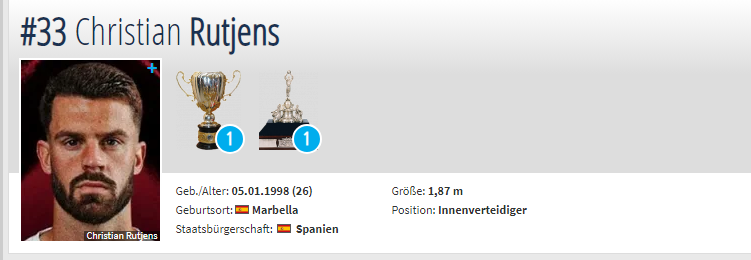

Since the player is spanish, lets just write in "ESP" now.

In [193]:
# First, find the index of the player 'Christian Rutjens'
index = df[df['player'] == 'Christian Rutjens'].index

# Update the 'nationality_code' column for this player using loc
df.loc[index, 'nationality_code'] = 'ESP'
print("Nationality code updated successfully.")

Nationality code updated successfully.


In [194]:
df[['player', 'nationality', 'nationality_code']][df['player']=='Christian Rutjens']

,player,nationality,nationality_code
2223,Christian Rutjens,0,ESP


In [195]:
columns_to_remove.extend(['nationality']) # Add the column to the list of columns to remove

#### 2.4.2 `position`<a name = "sub242"></a>

In [196]:
# Count the number of positions each player can play
df['positions_played'] = df['position'].str.split(',').apply(lambda x: len(x) if x[0] != '' else 0)

In [197]:
df[['player', 'position', 'positions_played']].head()

,player,position,positions_played
0,Burgui,"FW,MF",2
1,Raphaël Varane,DF,1
2,Rubén Duarte,DF,1
3,Samuel Umtiti,DF,1
4,Manu García,MF,1


#### 2.4.3 `position2`<a name = "sub243"></a>

In [198]:
# Splitting the "position2" column into two separate columns: "position_type" and "specific_position"
df[["position_type", "specific_position"]] = df["position2"].str.split(" - ", expand=True)

In [199]:
df[['player', 'position2', 'position_type', 'specific_position']].head()

,player,position2,position_type,specific_position
0,Burgui,attack - Left Winger,attack,Left Winger
1,Raphaël Varane,Defender - Centre-Back,Defender,Centre-Back
2,Rubén Duarte,Defender - Left-Back,Defender,Left-Back
3,Samuel Umtiti,Defender - Centre-Back,Defender,Centre-Back
4,Manu García,midfield - Defensive Midfield,midfield,Defensive Midfield


### Standardization of Position Formatting

#### Discovering Inconsistencies
During our data review process, inconsistencies were noted in the formatting of the `position_type` and `specific_position` columns. Specifically, issues were identified with inconsistent capitalization and the use of hyphens in position names (e.g., "Left Winger" vs. "Centre-Back").

#### Action Taken
To ensure consistency and improve the clarity of our dataset, we implemented standardization measures using Python's pandas library:
- **Capitalization**: We standardized all entries in `position_type` to start with a capital letter followed by lowercase letters, ensuring uniformity across this column.
- **Hyphen Usage**: For `specific_position`, we ensured that all multi-word positions are hyphenated (e.g., transforming "Left Winger" to "Left-Winger"), which aligns with how other compound names like "Centre-Back" are formatted.


In [200]:
# Ensure all transformations are lowercase first to handle case inconsistencies
df['position_type'] = df['position_type'].str.capitalize()

# Handle None values and standardize 'specific_position' to ensure uniform hyphen usage
df['specific_position'] = df['specific_position'].apply(lambda x: '-'.join(w.capitalize() for w in x.split()) if x else x)

# Output the cleaned DataFrame
df[['player', 'position2', 'position_type', 'specific_position']].head()

,player,position2,position_type,specific_position
0,Burgui,attack - Left Winger,Attack,Left-Winger
1,Raphaël Varane,Defender - Centre-Back,Defender,Centre-back
2,Rubén Duarte,Defender - Left-Back,Defender,Left-back
3,Samuel Umtiti,Defender - Centre-Back,Defender,Centre-back
4,Manu García,midfield - Defensive Midfield,Midfield,Defensive-Midfield


In [201]:
columns_to_remove.extend(['position2']) # Add the columns to the list of columns to remove

#### 2.5 First conclusions<a name = "sub25"></a>

Since this dataset contains 800 rows it is recommended not to drop any Pokémon. This could make it more difficult to draw conclusions from the dataset.<br>
<br>
Possible solutions:
- **`Unnamed: 0` and `Column1`**: Merge into a new column `player_id` to consolidate the data and reduce redundancy. This will simplify the dataset's structure and ensure the completeness of player identification data.
- **`CLBestScorer`**: Remove this feature due to its low correlation with the target and predominance of zero values. This action will streamline the dataset, focusing analysis on more impactful variables.
- **183 features with 1.892202% missing data**: Implement advanced imputation techniques to address the consistent missing entries, considering the extensive number of affected features. Advanced imputation methods like multivariate imputation will be used to minimize the introduction of bias. Removal of these features will be considered only if imputation proves insufficient or adversely affects the data quality.
- **`nationality`**: Simplify by retaining only the uppercase acronym to standardize the format across the dataset.
- **`position`**: Transform into `amount_positions` by counting how many positions a player can play, turning it into a numeric feature that reflects player versatility.
- **`position2`**: Split into `position_type` and `specific_position` to allow more precise analysis and modeling by distinguishing between general position categories and specific roles.
- **`height` and `foot`**: Apply imputation techniques for the few missing entries in these features to maintain data integrity without significant disruption.



### Step 3: Save the cleaned dataset <a name = "third"></a>

In [202]:
df.drop(columns=columns_to_remove, inplace=True) # Drop the columns that are no longer needed

In [203]:
df.shape

(6976, 402)

In [204]:
df.columns.values

array(['player', 'position', 'squad', 'age', 'birth_year', 'value',
       'height', 'foot', 'league', 'games', 'games_starts', 'minutes',
       'goals', 'assists', 'pens_made', 'pens_att', 'cards_yellow',
       'cards_red', 'goals_per90', 'assists_per90', 'goals_assists_per90',
       'goals_pens_per90', 'goals_assists_pens_per90', 'xg', 'npxg', 'xa',
       'xg_per90', 'xa_per90', 'xg_xa_per90', 'npxg_per90',
       'npxg_xa_per90', 'minutes_90s', 'shots_total', 'shots_on_target',
       'shots_free_kicks', 'shots_on_target_pct', 'shots_total_per90',
       'shots_on_target_per90', 'goals_per_shot',
       'goals_per_shot_on_target', 'npxg_per_shot', 'xg_net', 'npxg_net',
       'passes_completed', 'passes', 'passes_pct',
       'passes_total_distance', 'passes_progressive_distance',
       'passes_completed_short', 'passes_short', 'passes_pct_short',
       'passes_completed_medium', 'passes_medium', 'passes_pct_medium',
       'passes_completed_long', 'passes_long', 'passes_pct_l

In [205]:
df.to_csv("football_cleaned.csv", index = False)